This notebook aims to develop a machine learning model for crowd number estimation from a single
image at random crowd density and arbitrary perspective. We have proposed a multi- column
convolutional neural network (MCNN) architecture to map Image of a crowd density map. MCNN
allows the input image to be of any size or resolution. through the use of filters with receptive
fields of different sizes, And also, regardless of the size of the people. Moreover, the true density
map is calculated precisely based on engineering adaptation kernels. We have collected and
classified a group of 300 images and created a data Augmentation of images, bringing the training
data to 2439 images and verification data of 261 images, we are conducting extensive trials to
verify the effectiveness of the proposed model and method. In particular, with the proposed
simple MCNN model, our method It beats all existing styles. In addition to the experiments Show
that our model, once trained on it.
 show that our model, once trained on one dataset, can be readily transferred to a new dataset
 
 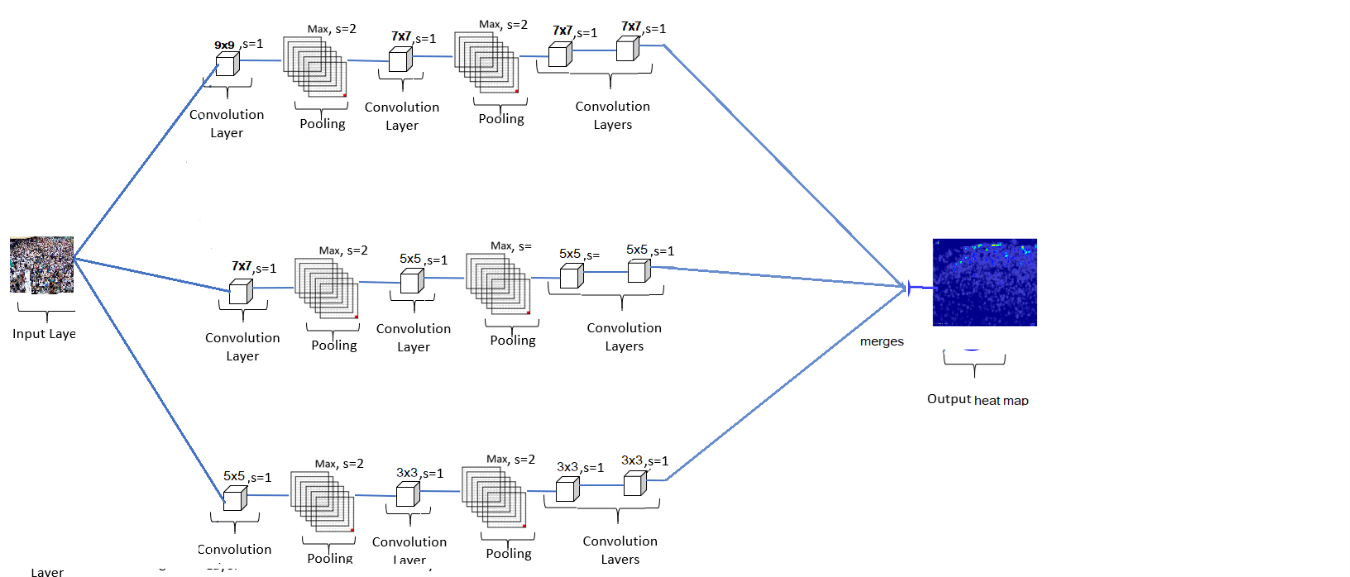


In [1]:
#Definition of library
!pip install pykdtree
!pip install kdtree

import os
import cv2
import csv
import argparse
from scipy.io import loadmat
import csv
import math
import random
from scipy.io import loadmat
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
import pandas as pd
import numpy as np
import keras.backend as K
from pykdtree.kdtree import KDTree
import glob
import h5py
from scipy.io import loadmat
from tqdm import tqdm
import h5py
import scipy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
#from utils_gen import gen_density_map_gaussian



     |████████████████████████████████| 212 kB 4.3 MB/s 


this class  gen_density_map 
Generate density map matrix
whitch has  param img: 2d array, image array
param anno_points: 2d array, labeled human head coordinates, shape(nums,2) to return: 2d array



class DataLoader 
to data preperation 
param data_path: image file path
param gt_path: ground truth path
param shuffle: bool, whether to shuffle the data
param gt_downsample: bool, whether to downsample


In [2]:

def gen_density_map(img, anno_points):
   
    density_map = np.zeros_like(img, dtype=np.float64)
    h, w = density_map.shape
    kernel_size = 15 # Gaussian kernel size
    sigma = 4.0 # standard deviation

    for point in anno_points:
        # Center point coordinates of human head
        x, y = min(w-1, abs(math.floor(point[0]))), min(h-1, abs(math.floor(point[1])))
        # Upper left corner coordinates and lower right corner coordinates
        x1, y1 = x-kernel_size // 2, y-kernel_size // 2
        x2, y2 = x + kernel_size // 2 + 1, y + kernel_size // 2 + 1

        out_of_bounds = False
        dx1, dy1, dx2, dy2 = 0, 0, 0, 0 # Out of bounds offset
        # The following four ifs are used to determine whether the x and y of the two top corners are out of bounds
        if x1 <0:
            dx1 = abs(x1)
            x1 = 0
            out_of_bounds = True
        if y1 <0:
            dy1 = abs(y1)
            y1 = 0
            out_of_bounds = True
        if x2> w:
            dx2 = x2-w
            x2 = w
            out_of_bounds = True
        if y2> h:
            dy2 = y2-h
            y2 = h
            out_of_bounds = True

        if out_of_bounds:
            # If it is out of bounds, adjust the size of the Gaussian kernel
            kernel_h = kernel_size-dy1-dy2
            kernel_w = kernel_size-dx1-dx2
            # Generate a Gaussian kernel of size (kernel_h, kernel_w)
            H = np.multiply(cv2.getGaussianKernel(kernel_h, sigma), (cv2.getGaussianKernel(kernel_w, sigma)).T)
        else:
            # Generate a Gaussian kernel of size (15, 15)
            H = np.multiply(cv2.getGaussianKernel(kernel_size, sigma), (cv2.getGaussianKernel(kernel_size, sigma)).T)

        density_map[y1:y2, x1:x2] += H
    return density_map


class DataLoader(object):
    def __init__(self, data_path, gt_path, shuffle=False, gt_downsample=False):
     
        self.data_path = data_path
        self.gt_path = gt_path
        self.shuffle = shuffle
        self.gt_downsample = gt_downsample
        self.data_files = [filename for filename in os.listdir(data_path)]
        self.num_samples = len(self.data_files)
        self.blob_list = []

        for fname in self.data_files:
            img = cv2.imread(os.path.join(self.data_path, fname), 0)
            img = img.astype(np.float32, copy=False)
            ht = img.shape[0]
            wd = img.shape[1]
            ht_1 = int((ht / 4) * 4)
            wd_1 = int((wd / 4) * 4)
            img = cv2.resize(img, (wd_1, ht_1))
            img = img.reshape((img.shape[0], img.shape[1], 1))
            den = pd.read_csv(os.path.join(self.gt_path, os.path.splitext(fname)[0] +'.csv'),
                              header=None).values
            den = den.astype(np.float32, copy=False)
            if self.gt_downsample:
                wd_1 = int(wd_1 / 4)
                ht_1 = int(ht_1 / 4)
            den = cv2.resize(den, (wd_1, ht_1))
            den = den * ((wd * ht) / (wd_1 * ht_1))
            den = den.reshape((den.shape[0], den.shape[1], 1))

            blob = dict()
            blob['data'] = img
            blob['gt'] = den
            blob['fname'] = fname
            self.blob_list.append(blob)

        if self.shuffle:
            np.random.shuffle(self.blob_list)

    def flow(self, batch_size=32):
        loop_count = self.num_samples // batch_size
        while True:
            np.random.shuffle(self.blob_list)
            for i in range(loop_count):
                blobs = self.blob_list[i*batch_size: (i+1)*batch_size]
                X_batch = np.array([blob['data'] for blob in blobs])
                Y_batch = np.array([blob['gt'] for blob in blobs])
                yield X_batch, Y_batch

    def get_all(self):
        X = np.array([blob['data'] for blob in self.blob_list])
        Y = np.array([blob['gt'] for blob in self.blob_list])
        return X, Y

    def __iter__(self):
        for blob in self.blob_list:
            yield blob

def mae(y_true, y_pred):
    return K.abs(K.sum(y_true) - K.sum(y_pred))

def mse(y_true, y_pred):
    return (K.sum(y_true) - K.sum(y_pred)) * (K.sum(y_true) - K.sum(y_pred))


In [3]:
EPOCHS = 200
TRAIN_BATCH_SIZE = 1
VAL_BATCH_SIZE = 1
dataset = 'A'
MODEL_DIR = './trained_models/'
TRAIN_PATH = './data/formatted_trainval_{0}/shanghaitech_part_{0}_patches_9/train'
TRAIN_GT_PATH = './data/formatted_trainval_{0}/shanghaitech_part_{0}_patches_9/train_den'
VAL_PATH = './data/formatted_trainval_{0}/shanghaitech_part_{0}_patches_9/val'
VAL_GT_PATH = './data/formatted_trainval_{0}/shanghaitech_part_{0}_patches_9/val_den'

TEST_PATH = './data/original/shanghaitech/part_{}_final/test_data/images/'
TEST_GT_PATH = './data/original/shanghaitech/part_{}_final/test_data/ground_truth_csv/'
HM_GT_PATH = './heatmaps_gt'

path = '../input/shanghaitech/part_A/train_data/images/'
gt_path = '../input/shanghaitech/part_A/train_data/ground_truth/'
gt_path_csv = './ground_truth_csv/'

if not os.path.exists(gt_path_csv):
    os.makedirs(gt_path_csv)
#num image
num_images = 300
x=''.join((gt_path,'GT_IMG_1', '.mat'))
print(x)

../input/shanghaitech/part_A/train_data/ground_truth/GT_IMG_1.mat


In [4]:



num_val = math.ceil(num_images * 0.1)  
indices = list(range(1, num_images + 1))
random.shuffle(indices)

for idx in range(num_images):


    i = indices[idx]
    if (idx+1) % 10 == 0:
        print('Processing {}/{} files'.format(idx+1, num_images))
    
    input_img_name = ''.join((path, 'IMG_', str(i), '.jpg'))
    if os.path.isfile(input_img_name):

      im = cv2.imread(input_img_name, 0)
      
      image_info = loadmat(''.join((gt_path, 'GT_IMG_', str(i), '.mat')))['image_info']
      annPoints = image_info[0][0][0][0][0] - 1
      
      im_density = gen_density_map.gen_density_map(im, annPoints)

      h, w = im.shape
      wn2, hn2 = w / 8, h / 8  
      wn2, hn2 = int(wn2 / 8) * 8, int(hn2 / 8) * 8  
      
      xmin, xmax = wn2, w - wn2
      ymin, ymax = hn2, h - hn2
      
      for j in range(1, N + 1):
          
          x = math.floor((xmax - xmin) * random.random() + xmin)
          y = math.floor((ymax - ymin) * random.random() + ymin)
          
          x1, y1 = x - wn2, y - hn2
          x2, y2 = x + wn2, y + hn2
          
          im_sampled = im[y1:y2, x1:x2]
          im_density_sampled = im_density[y1:y2, x1:x2]

          
          img_idx = ''.join((str(i), '_', str(j)))
          path_img, path_den = (val_path_img, val_path_den) if (idx+1) < num_val else (train_path_img, train_path_den)
          cv2.imwrite(''.join([path_img, img_idx, '.jpg']), im_sampled)
          with open(''.join([path_den, img_idx, '.csv']), 'w', newline='') as fout:
              writer = csv.writer(fout)
              writer.writerows(im_density_sampled)

          

Processing 10/300 files
Processing 20/300 files
Processing 30/300 files
Processing 40/300 files
Processing 50/300 files
Processing 60/300 files
Processing 70/300 files
Processing 80/300 files
Processing 90/300 files
Processing 100/300 files
Processing 110/300 files
Processing 120/300 files
Processing 130/300 files
Processing 140/300 files
Processing 150/300 files
Processing 160/300 files
Processing 170/300 files
Processing 180/300 files
Processing 190/300 files
Processing 200/300 files
Processing 210/300 files
Processing 220/300 files
Processing 230/300 files
Processing 240/300 files
Processing 250/300 files
Processing 260/300 files
Processing 270/300 files
Processing 280/300 files
Processing 290/300 files
Processing 300/300 files


In [5]:
dataset = 'A'
N = 9  
dataset_name = ''.join(['shanghaitech_part_', dataset, '_patches_', str(N)])
path = ''.join(['shanghaitech/part_', dataset, '/train_data/images/'])
output_path = 'data/formatted_trainval_{}/'.format(dataset)
train_path_img = ''.join((output_path, dataset_name, '/train/'))
train_path_den = ''.join((output_path, dataset_name, '/train_den/'))
val_path_img = ''.join((output_path, dataset_name, '/val/'))
val_path_den = ''.join((output_path, dataset_name, '/val_den/'))
gt_path = ''.join(['shanghaitech/part_', dataset, '/train_data/ground_truth/'])
print(gt_path)

for i in [output_path, train_path_img, train_path_den, val_path_img, val_path_den]:
    if not os.path.exists(i):
        os.makedirs(i)

shanghaitech/part_A/train_data/ground_truth/


In [6]:
import numpy as np

seed =26
random.seed(seed)
dataset = 'A'
N = 9  
dataset_name = ''.join(['shanghaitech_part_', dataset, '_patches_', str(N)])
path = '../input/shanghaitech/ShanghaiTech/part_A/train_data/images/'
output_path = 'data/formatted_trainval_{}/'.format(dataset)
train_path_img = ''.join((output_path, dataset_name, '/train/'))
train_path_den = ''.join((output_path, dataset_name, '/train_den/'))
val_path_img = ''.join((output_path, dataset_name, '/val/'))
val_path_den = ''.join((output_path, dataset_name, '/val_den/'))
gt_path = '../input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth/'
print(gt_path)

for i in [output_path, train_path_img, train_path_den, val_path_img, val_path_den]:
    if not os.path.exists(i):
        os.makedirs(i)

if dataset == 'A':
    num_images = 300
else:
    num_images = 400

num_val = math.ceil(num_images * 0.1) 
indices = list(range(1, num_images + 1))
random.shuffle(indices)

for idx in range(num_images):

  i = indices[idx]
  if (idx+1) % 10 == 0:
      print('Processing {}/{} files'.format(idx+1, num_images))
  
  input_img_name = ''.join((path, 'IMG_', str(i), '.jpg'))
  im = cv2.imread(input_img_name, 0)
  
  x11=''.join((gt_path, 'GT_IMG_', str(i), '.mat'))

  image_info = loadmat(''.join((gt_path, 'GT_IMG_', str(i), '.mat')))['image_info']
  annPoints = image_info[0][0][0][0][0] - 1

  density_map = np.zeros_like(im, dtype=np.float64)
  print(density_map.shape)
  
  im_density = gen_density_map(im, annPoints)
  
  h, w = im.shape
  wn2, hn2 = w / 8, h / 8  
  wn2, hn2 = int(wn2 / 8) * 8, int(hn2 / 8) * 8 
  xmin, xmax = wn2, w - wn2
  ymin, ymax = hn2, h - hn2
  for j in range(1, N + 1):
      x = math.floor((xmax - xmin) * random.random() + xmin)
      y = math.floor((ymax - ymin) * random.random() + ymin)
      x1, y1 = x - wn2, y - hn2
      x2, y2 = x + wn2, y + hn2
     
      im_sampled = im[y1:y2, x1:x2]
      im_density_sampled = im_density[y1:y2, x1:x2]
     
      img_idx = ''.join((str(i), '_', str(j)))
      path_img, path_den = (val_path_img, val_path_den) if (idx+1) < num_val else (train_path_img, train_path_den)
      cv2.imwrite(''.join([path_img, img_idx, '.jpg']), im_sampled)
      with open(''.join([path_den, img_idx, '.csv']), 'w', newline='') as fout:
          writer = csv.writer(fout)
          writer.writerows(im_density_sampled)
         


../input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth/
(585, 1024)
(611, 1021)
(683, 1024)
(768, 1024)
(334, 1024)
(391, 630)
(480, 722)
(430, 620)
(540, 1024)
Processing 10/300 files
(600, 903)
(579, 840)
(418, 628)
(551, 1024)
(801, 688)
(645, 1024)
(683, 1024)
(517, 800)
(544, 932)
(768, 1024)
Processing 20/300 files
(683, 1024)
(944, 1024)
(506, 487)
(663, 962)
(768, 1024)
(432, 700)
(530, 800)
(768, 1024)
(681, 1024)
(768, 1024)
Processing 30/300 files
(684, 1024)
(450, 970)
(342, 608)
(768, 1024)
(680, 1024)
(387, 580)
(768, 1024)
(768, 1024)
(680, 1024)
(665, 1024)
Processing 40/300 files
(563, 832)
(478, 359)
(683, 1024)
(267, 496)
(768, 1024)
(340, 562)
(598, 1024)
(594, 1024)
(684, 1024)
(681, 1024)
Processing 50/300 files
(640, 640)
(411, 443)
(450, 600)
(684, 1024)
(686, 1024)
(640, 480)
(279, 400)
(681, 1024)
(681, 1024)
(768, 1024)
Processing 60/300 files
(661, 1024)
(270, 360)
(774, 1024)
(600, 800)
(768, 1024)
(683, 1024)
(438, 736)
(1024, 832)
(683, 1024)
(

In [7]:
                           #prepaire data for train
train_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/train'
train_gt_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/train_den'
val_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/val'
val_gt_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/val_den'

print('Loading data, wait a moment...')
train_data_gen = DataLoader(train_path, train_gt_path, shuffle=True, gt_downsample=True)
val_data_gen = DataLoader(val_path, val_gt_path, shuffle=False, gt_downsample=True)

print('done')

Loading data, wait a moment...
done


Text(0, 0.5, 'count people')

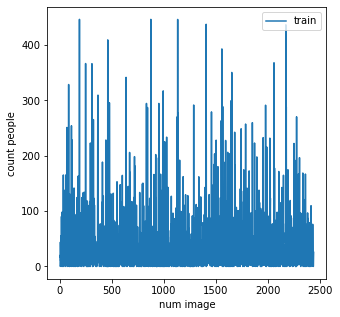

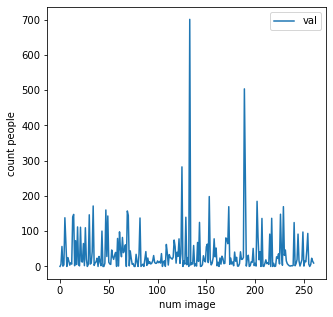

In [8]:
#explor data
import matplotlib.pyplot as plt

ct_gts = []
xx=0
for blob in train_data_gen:
    xx=xx+1
    gt = blob['gt']
    gt_count = np.sum(gt)
    ct_gts.append(gt_count)

len(ct_gts)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(range(2439),ct_gts,label='train')
ax.legend()
ax.set_xlabel('num image')
ax.set_ylabel('count people')
ct_gts2 = []
xx=0
for blob2 in val_data_gen:
    xx=xx+1
    gt2 = blob2['gt']
    gt_count2 = np.sum(gt2)
    ct_gts2.append(gt_count2)
fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(range(261),ct_gts2,label='val')
ax2.legend()
ax2.set_xlabel('num image')
ax2.set_ylabel('count people')


In [9]:
len(ct_gts2)

261

# **build modle MCNN**

In [10]:


from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Concatenate


def MCNN(input_shape=None):
    inputs = Input(shape=input_shape)

    # column 1
    column_1 = Conv2D(16, (9, 9), padding='same', activation='relu')(inputs)
    column_1 = MaxPooling2D(2)(column_1)
    column_1 = (column_1)
    column_1 = Conv2D(32, (7, 7), padding='same', activation='relu')(column_1)
    column_1 = MaxPooling2D(2)(column_1)
    column_1 = Conv2D(16, (7, 7), padding='same', activation='relu')(column_1)
    column_1 = Conv2D(8, (7, 7), padding='same', activation='relu')(column_1)

    # column 2
    column_2 = Conv2D(20, (7, 7), padding='same', activation='relu')(inputs)
    column_2 = MaxPooling2D(2)(column_2)
    column_2 = (column_2)
    column_2 = Conv2D(40, (5, 5), padding='same', activation='relu')(column_2)
    column_2 = MaxPooling2D(2)(column_2)
    column_2 = Conv2D(20, (5, 5), padding='same', activation='relu')(column_2)
    column_2 = Conv2D(10, (5, 5), padding='same', activation='relu')(column_2)

    # column 3
    column_3 = Conv2D(24, (5, 5), padding='same', activation='relu')(inputs)
    column_3 = MaxPooling2D(2)(column_3)
    column_3 = (column_3)
    column_3 = Conv2D(48, (3, 3), padding='same', activation='relu')(column_3)
    column_3 = MaxPooling2D(2)(column_3)
    column_3 = Conv2D(24, (3, 3), padding='same', activation='relu')(column_3)
    column_3 = Conv2D(12, (3, 3), padding='same', activation='relu')(column_3)

    # merge feature map of 3 columns in last dimension
    merges = Concatenate(axis=-1)([column_1, column_2, column_3])
    # density map
    density_map = Conv2D(1, (1, 1), padding='same')(merges)

    model = Model(inputs=inputs, outputs=density_map)
    return model


# new train
 

In [11]:
#new train
input_shape = (None, None, 1)
model = MCNN(input_shape)

adam = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=adam, metrics=[mae, mse])


checkpointer_best_train = ModelCheckpoint(
    filepath='../input/data11/final_model3 .h5',
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

callback_list = [checkpointer_best_train]


print('done prepaire {} ...'.format(dataset))
model.summary()



done prepaire A ...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 1312        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 2 1000        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 2 624         input_1[0][0]                    
__________________________________________________________________________

# intialize wights  resume from last train(transfer learning)


In [12]:
# intialize wights  resume from last train(transfer learning)
#model_path = '/content/drive/MyDrive/final_model153.h5'
model_path = '../input/data11/final_model32.h5'
model = load_model(model_path)
adam = Adam(lr=0.00000001)
model.compile(loss='mse', optimizer=adam, metrics=[mae, mse])

checkpointer_best_train = ModelCheckpoint(
    filepath='./final_model3.h5',
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)
callback_list = [checkpointer_best_train]
model.summary()
if not os.path.exists('models'):
    os.makedirs('models')
#plot_model(model, 'models/{}.png')
with open('./models/{}.json', 'w') as fout:
    fout.write(model.to_json())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1312        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 2 1000        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 2 624         input_1[0][0]                    
____________________________________________________________________________________________

# start train 


In [13]:
#start train 1
print ("start train..........")

h=model.fit(train_data_gen.flow(1),
                    steps_per_epoch=train_data_gen.num_samples // 1,
                    validation_data=val_data_gen.flow(1),
                    validation_steps=val_data_gen.num_samples // 1,
                    epochs=30,
                    callbacks=callback_list,
                    verbose=1)

start train..........
Epoch 1/30
2439/2439 [==============================] - 28s 10ms/step - loss: 0.0013 - mae: 10.6618 - mse: 320.8596 - val_loss: 0.0017 - val_mae: 12.2510 - val_mse: 685.0704

Epoch 00001: loss improved from inf to 0.00145, saving model to ./final_model3.h5
Epoch 2/30
2439/2439 [==============================] - 16s 6ms/step - loss: 0.0014 - mae: 11.2347 - mse: 369.3764 - val_loss: 0.0017 - val_mae: 12.2287 - val_mse: 684.4676

Epoch 00002: loss improved from 0.00145 to 0.00145, saving model to ./final_model3.h5
Epoch 3/30
2439/2439 [==============================] - 16s 6ms/step - loss: 0.0014 - mae: 11.3722 - mse: 408.9754 - val_loss: 0.0017 - val_mae: 12.2829 - val_mse: 685.2855

Epoch 00003: loss improved from 0.00145 to 0.00145, saving model to ./final_model3.h5
Epoch 4/30
2439/2439 [==============================] - 16s 7ms/step - loss: 0.0015 - mae: 11.7278 - mse: 448.7906 - val_loss: 0.0016 - val_mae: 12.2358 - val_mse: 684.0349

Epoch 00004: loss improved 

In [14]:
hist_df = pd.DataFrame(h.history) 

#  save history of accurcy to csv: 
hist_df = pd.DataFrame(h.history) 
#  save history of accurcy to csv: 
hist_csv_file = './history3.csv'
with open(hist_csv_file, mode='a') as f:
    hist_df.to_csv(f)

# read accurcy as plot


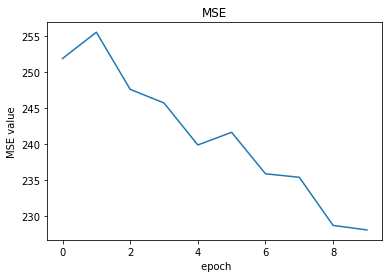

In [15]:
#read accurcy as plot

import pandas as pd

f=pd.read_csv('../input/data11/history3.csv')  

import matplotlib.pyplot as plt

plt.plot(f['mse'], label='MSE (training data)')

plt.title('MSE')
plt.ylabel('MSE value')
plt.xlabel(' epoch')
plt.show()

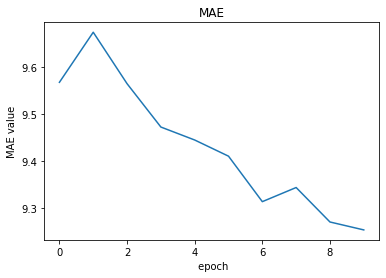

In [16]:
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel(' epoch')
plt.plot(f['mae'])
plt.show()

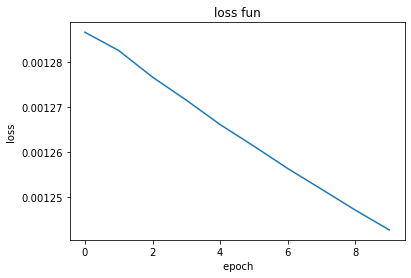

In [17]:
#read accurcy as plot
import pandas as pd
f=pd.read_csv('../input/data11/history3.csv')  
import matplotlib.pyplot as plt
plt.plot(f['loss'], label='MSE (training data)')
plt.title('loss fun')
plt.ylabel('loss ')
plt.xlabel(' epoch')
plt.show()

In [18]:
#transfer learning
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

                                     #prepaire
train_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/train/'
train_gt_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/train_den/'
val_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/val/'
val_gt_path = './data/formatted_trainval_A/shanghaitech_part_A_patches_9/val_den/'
train_data_gen = DataLoader(train_path, train_gt_path, shuffle=True, gt_downsample=True)
val_data_gen = DataLoader(val_path, val_gt_path, shuffle=False, gt_downsample=True)


In [19]:
#transfer learning
model_path = 'final_model3.h5'

output_dir = 'test'
heatmaps_dir ='test/'  # directory to save heatmap
results_txt = 'test/r/ ' # file to save predicted results
numtest=10
test_path ='./data/formatted_trainval_A/shanghaitech_part_A_patches_9/val'
test_gt_path ='./data/formatted_trainval_A/shanghaitech_part_A_patches_9/val_den'
# load test set
print('Loading data, wait a moment...')
data_loader = DataLoader(test_path, test_gt_path, shuffle=False, gt_downsample=True)

Loading data, wait a moment...


Testing Part_A ...


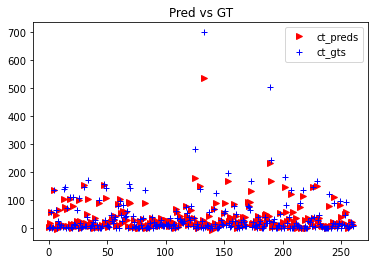

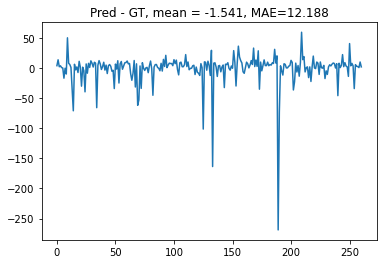

MAE: 12.19, MSE: 26.07
MAE: 12.19, MSE: 26.07


In [20]:
                                            ##Test
import matplotlib.pyplot as plt

#print('Loading data, wait a moment...')
#data_loader = DataLoader(test_path, test_gt_path, shuffle=False, gt_downsample=True)
# load model
#model = load_model(model_path)
# test
print('Testing Part_{} ...'.format(dataset))
mae = 0.0
mse = 0.0
u=0

ct_preds = []
ct_gts = []
xx=0
for blob in data_loader:
    xx=xx+1
    img = blob['data']
    gt = blob['gt']
    pred = model.predict(np.expand_dims(img, axis=0))
    gt_count = np.sum(gt)
    pred_count = np.sum(pred)
    ct_preds.append(pred_count)
    ct_gts.append(gt_count)

  
    mae += abs(gt_count - pred_count)
    mse += ((gt_count - pred_count) * (gt_count - pred_count))
    # create and save heatmap
    pred = np.squeeze(pred)  # shape(1, h, w, 1) -> shape(h, w)

    #save_heatmap(pred, blob, test_path, heatmaps_dir)#error
    #print(test_path)
    # save results
    #print('<{}> {:.2f} -- {:.2f}\n'.format(blob['fname'].split('.')[0], gt_count, pred_count))
   # with open(results_txt, 'a') as f:
        #line = '<{}> {:.2f} -- {:.2f}\n'.format(blob['fname'].split('.')[0], gt_count, pred_count)
        #f.write(line)
plt.plot(ct_preds, 'r>')
plt.plot(ct_gts, 'b+')
plt.legend(['ct_preds', 'ct_gts'])
plt.title('Pred vs GT')
plt.show()
error = np.array(ct_preds) - np.array(ct_gts)
plt.plot(error)
plt.title('Pred - GT, mean = {}, MAE={}'.format(
    str(round(np.mean(error), 3)),
    str(round(np.mean(np.abs(error)), 3))
))
plt.show()
idx_max_error = np.argsort(np.abs(error))[::-1]

mae = mae / data_loader.num_samples
mse = np.sqrt(mse / data_loader.num_samples)
print('MAE: %0.2f, MSE: %0.2f' % (mae, mse))
#with open(results_txt, 'a') as f:
   # f.write('MAE: %0.2f, MSE: %0.2f' % (mae, mse))

print('MAE: %0.2f, MSE: %0.2f' % (mae, mse))


In [21]:


def smallize_density_map(density_map, stride=1):
    if stride > 1:
        density_map_stride = np.zeros((np.asarray(density_map.shape).astype(int)//stride).tolist(), dtype=np.float32)
        for r in range(density_map_stride.shape[0]):
            for c in range(density_map_stride.shape[1]):
                density_map_stride[r, c] = np.sum(density_map[r*stride:(r+1)*stride, c*stride:(c+1)*stride])
    else:
        density_map_stride = density_map
    return density_map_stride


def norm_by_imagenet(img):
    if len(img.shape) == 3:
        img = img / 255.0
        img[:, :, 0] = (img[:, :, 0] - 0.485) / 0.229
        img[:, :, 1] = (img[:, :, 1] - 0.456) / 0.224
        img[:, :, 2] = (img[:, :, 2] - 0.406) / 0.225
        return img
    elif len(img.shape) == 4 or len(img.shape) == 1:
        # In SHA, shape of images varies, so the array.shape is (N, ), that's the '== 1' case.
        imgs = []
        for im in img:
            im = im / 255.0
            im[:, :, 0] = (im[:, :, 0] - 0.485) / 0.229
            im[:, :, 1] = (im[:, :, 1] - 0.456) / 0.224
            im[:, :, 2] = (im[:, :, 2] - 0.406) / 0.225
            imgs.append(im)
        return np.array(imgs)
    else:
        print('Wrong shape of the input.')
        return None



def image_preprocessing(x, y, flip_hor=False, brightness_shift=False):
    xs, ys = [], []
    for idx_pro in range(x.shape[0]):
        x_, y_ = x[idx_pro], y[idx_pro]
        # preprocessings -----
        if flip_hor:
            x_, y_ = flip_horizontally(x_, y_)
        # preprocessings -----
        x_ = norm_by_imagenet(x_)
        xs.append(x_)
        ys.append(y_)
    xs, ys = np.array(xs), np.array(ys)
    return xs, ys


def flip_horizontally(x, y):
    to_flip = np.random.randint(0, 2)
    if to_flip:
        x, y = cv2.flip(x, 1), np.expand_dims(cv2.flip(np.squeeze(y), 1), axis=-1)
        # Suppose shape of y is (123, 456, 1), after cv2.flip, shape of y would turn into (123, 456).
    return x, y


def fix_singular_shape(img, unit_len=16):
    """
    Some network like w-net has both N maxpooling layers and concatenate layers,
    so if no fix for their shape as integeral times of 2 ** N, the shape will go into conflict.
    """
    hei_dst, wid_dst = img.shape[0] + (unit_len - img.shape[0] % unit_len), img.shape[1] + (unit_len - img.shape[1] % unit_len)
    if len(img.shape) == 3:
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
    elif len(img.shape) == 2:
        GT = int(round(np.sum(img)))
        img = cv2.resize(img, (wid_dst, hei_dst), interpolation=cv2.INTER_LANCZOS4)
        img = img / (np.sum(img) / GT)
    return img

def gen_paths_img_dm(path_file_root='data/paths_train_val_test', dataset='A'):
    path_file_root_curr = os.path.join(path_file_root, 'paths_'+dataset)
    img_paths = []
    dm_paths = []
    paths = os.listdir(path_file_root_curr)[:2]
    for i in sorted([os.path.join(path_file_root_curr, p) for p in paths]):
        with open(i, 'r') as fin:
            img_paths.append(
                sorted(
                    [l.rstrip() for l in fin.readlines()],
                    key=lambda x: int(x.split('_')[-1].split('.')[0]))
            )
        with open(i, 'r') as fin:
            dm_paths.append(
                sorted(
                    [l.rstrip().replace('images', 'ground').replace('.jpg', '.h5') for l in fin.readlines()],
                    key=lambda x: int(x.split('_')[-1].split('.')[0]))
            )
    return img_paths, dm_paths


def gen_var_from_paths(paths, stride=1, unit_len=16):
    vars = []
    format_suffix = paths[0].split('.')[-1]
    if format_suffix == 'h5':
        for ph in paths:
            dm = h5py.File(ph, 'r')['density'].value.astype(np.float32)
            if unit_len:
                dm = fix_singular_shape(dm, unit_len=unit_len)
            dm = smallize_density_map(dm, stride=stride)
            vars.append(np.expand_dims(dm, axis=-1))
    elif format_suffix == 'jpg':
        for ph in paths:
            raw = cv2.cvtColor(cv2.imread(ph), cv2.COLOR_BGR2RGB).astype(np.float32)
            if unit_len:
                raw = fix_singular_shape(raw, unit_len=unit_len)
            vars.append(raw)
        # vars = norm_by_imagenet(vars)
    else:
        print('Format suffix is wrong.')
    return np.array(vars)


def gen_density_map_gaussian(im, points, sigma=4):
    """
    func: generate the density map
    """
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map
    if sigma == 4:
        # Adaptive sigma in CSRNet.
        leafsize = 2048
        tree = KDTree(points.copy(), leafsize=leafsize)
        distances, _ = tree.query(points, k=4)
    for idx_p, p in enumerate(points):
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        gaussian_radius = sigma * 2 - 1
        if sigma == 4:
            # Adaptive sigma in CSRNet.
            sigma = max(int(np.sum(distances[idx_p][1:4]) * 0.1), 1)
            gaussian_radius = sigma * 3
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma),
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma).T
        )
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        gaussian_map = gaussian_map[y_up:y_down, x_left:x_right]
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        density_map[
            max(0, p[0]-gaussian_radius):min(h, p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(w, p[1]+gaussian_radius+1)
        ] += gaussian_map
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map

In [22]:

#../input/shanghaitech/ShanghaiTech/part_A/test_data/images/IMG_1.jpg
root = '../input/shanghaitech/ShanghaiTech/'
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

482
716


In [23]:
root = './shanghaitech/'

dm_paths=[]
img_path1=[]

for dataset in ['A']:
    img_paths = eval('img_paths_'+dataset)
    for img_path in tqdm(img_paths_A):
        img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)
        sigma = 4  if 'part_A' in img_path else 15
        k = np.zeros((img.shape[0], img.shape[1]))
        gt = pts["image_info"][0, 0][0, 0][0]
        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1

        DM = gen_density_map_gaussian(k, gt, sigma=sigma)

        file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground').replace('../input/shanghaitech/ShanghaiTech/part_A/train_data/ground/', './models').replace('../input/shanghaitech/ShanghaiTech/part_A/test_data/ground/', './models')
        dm_paths.append(file_path)
        img_path1.append(img_path)
        
        with h5py.File(file_path, 'w') as hf:
            hf['density'] = DM

100%|██████████| 482/482 [00:48<00:00,  9.84it/s]


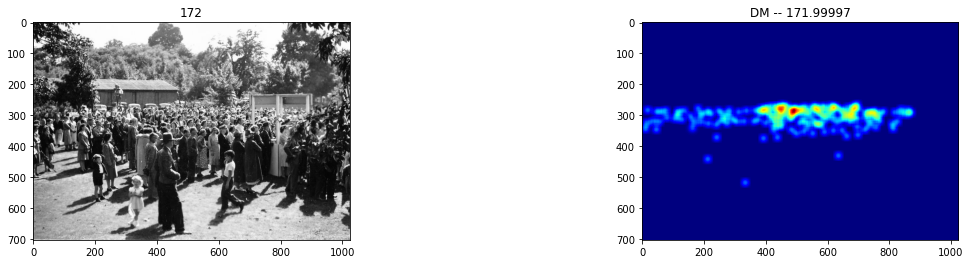

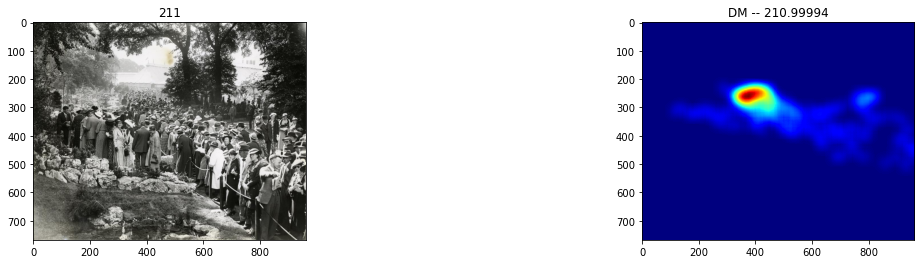

In [24]:
# Show a sample
img_paths = ['../input/shanghaitech/ShanghaiTech/part_A/test_data/images/IMG_1.jpg',
             '../input/shanghaitech/ShanghaiTech/part_A/test_data/images/IMG_101.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()

In [25]:

#important to perpair data
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.ioff()


test_img_paths=img_path1
test_dm_paths=dm_paths
# Settings
net = 'CSRNet'
dataset = "A"
# Generate paths of (train, test) x (img, dm)

# Generate raw images(normalized by imagenet rgb) and density maps
test_x, test_y = gen_var_from_paths(test_img_paths[:], unit_len=None), gen_var_from_paths(test_dm_paths[:], stride=8, unit_len=None)


test_x = norm_by_imagenet(test_x)  # Normalization on raw images in test set, those of training set are in image_preprocessing below.
print('Test data size:', test_x.shape[0], test_y.shape[0], len(test_img_paths))
#train_x, train_y = gen_var_from_paths(train_img_paths[:], unit_len=None), gen_var_from_paths(train_dm_paths[:], stride=8, unit_len=None)
#print('Train data size:', train_x.shape[0], train_y.shape[0], len(train_img_paths))
# Delete the directory for saving weights during last training.
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:98: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Test data size: 482 482 482


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0/482
100/482
200/482
300/482
400/482


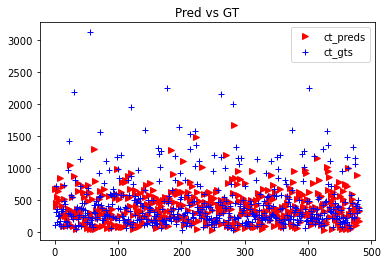

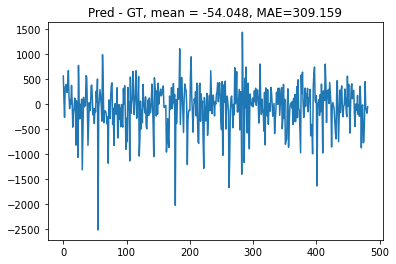

In [26]:

ct_preds = []
ct_gts = []
for i in range(len(test_x[:])):
    if i % 100 == 0:
        print('{}/{}'.format(i, len(test_x)))
    i += 0
    test_x_display = np.squeeze(test_x[i])
    test_y_display = np.squeeze(test_y[i])
    path_test_display = test_img_paths[i]

    img = test_x[i][:,:,0]

    img = img.astype(np.float32, copy=False)
    ht = img.shape[0]
    wd = img.shape[1]
    ht_1 = int((ht / 4) * 4)
    wd_1 = int((wd / 4) * 4)
    img = cv2.resize(img, (wd_1, ht_1))
    img = img.reshape((img.shape[0], img.shape[1], 1))

    #pred = model.predict(np.expand_dims(img, axis=0))

    pred = np.squeeze(model.predict(np.expand_dims(img, axis=0)))

    ct_pred = np.sum(pred)
    ct_gt = round(np.sum(test_y_display))
    ct_preds.append(ct_pred)
    ct_gts.append(ct_gt)
plt.plot(ct_preds, 'r>')
plt.plot(ct_gts, 'b+')
plt.legend(['ct_preds', 'ct_gts'])
plt.title('Pred vs GT')
plt.show()
error = np.array(ct_preds) - np.array(ct_gts)
plt.plot(error)
plt.title('Pred - GT, mean = {}, MAE={}'.format(
    str(round(np.mean(error), 3)),
    str(round(np.mean(np.abs(error)), 3))
))
plt.show()
idx_max_error = np.argsort(np.abs(error))[::-1]


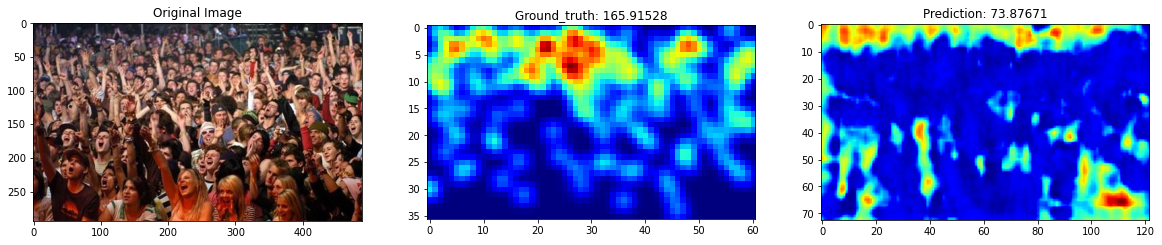

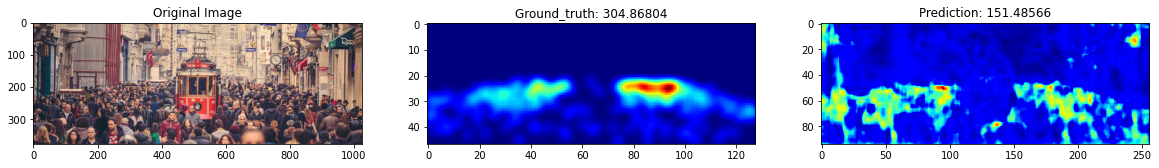

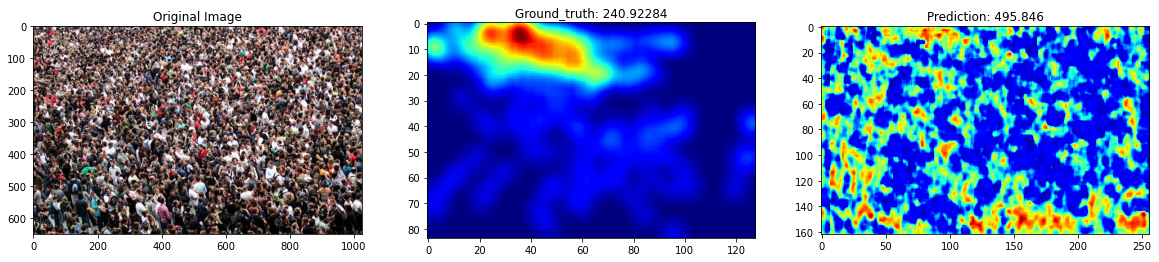

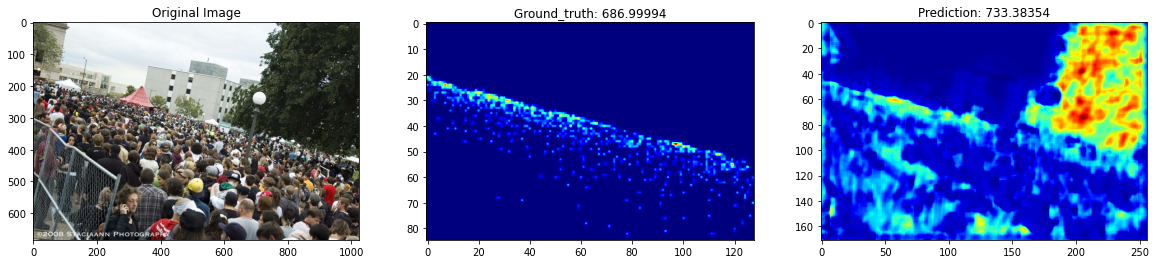

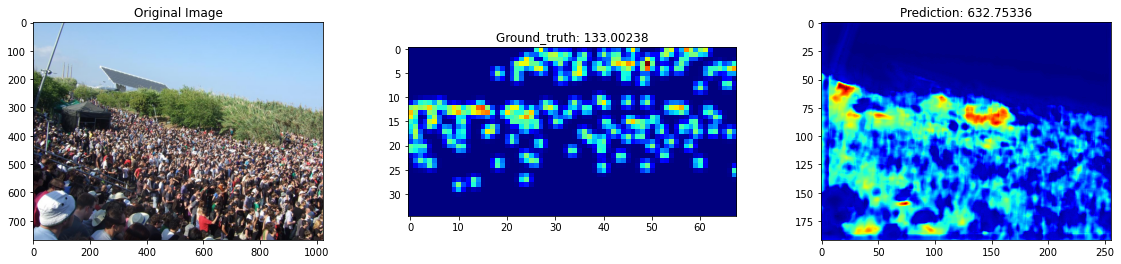

In [27]:

# Show rowndom samples
for worst_idx in range(50,55):
    test_x_display = np.squeeze(test_x[worst_idx])
    test_y_display = np.squeeze(test_y[worst_idx])
    path_test_display = test_img_paths[worst_idx]
    test_x_display = np.squeeze(test_x[worst_idx])
    test_y_display = np.squeeze(test_y[worst_idx])
    path_test_display = test_img_paths[worst_idx]

    img = test_x[worst_idx][:,:,0]

    img = img.astype(np.float32, copy=False)
    ht = img.shape[0]
    wd = img.shape[1]
    ht_1 = int((ht / 4) * 4)
    wd_1 = int((wd / 4) * 4)
    img = cv2.resize(img, (wd_1, ht_1))
    img = img.reshape((img.shape[0], img.shape[1], 1))

    


    pred = np.squeeze(model.predict(np.expand_dims(img, axis=0)))



    fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
    ax_x_ori.imshow(cv2.cvtColor(cv2.imread(path_test_display), cv2.COLOR_BGR2RGB))
    ax_x_ori.set_title('Original Image')
    ax_y.imshow(test_y_display, cmap=plt.cm.jet)
    ax_y.set_title('Ground_truth: ' + str(np.sum(test_y_display)))
    ax_pred.imshow(pred, cmap=plt.cm.jet)
    ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
    plt.show()